# Classical geostatistics (geosclassic wrapper) - examples 2D

Estimation and simulation for a continuous variable in a 2D grid, based on simple and ordinary kriging.
- estimation: estimate and standard deviation with simple and ordinary kriging
    - hard data only
    - search ellipsoid or unique neighborhood
- simulation: sequential gaussian simulation (SGS) based on simple and ordinary kriging
    - hard data and inequality data
    - search ellipsoid only

The covariance model can be
- stationary, *i.e.* any parameter (weight (or sill), ranges, orientation angle, etc.) is constant
- non-stationary, *i.e.* with some parameter (weight (or sill), ranges, orientation angle, etc.) depending on the location in the grid. *Note:* with a non-stationary covariance model
    - some functionalities such as getting the sill, range, or plotting the model are not available
    - a unique neighborhood can not be used for estimation

Simple kriging allows to specify the mean and the variance, stationary (global) or non-stationary (local). By default the mean is set to the mean of the hard data values (stationary) or zero if no hard data is present, and the variance is determined by the covariance model used and not modified.

The mean can also specified with ordinary kriging: in this case, the specified mean is used when estimation or simulation is done in a grid cell without any neighbor.

**Remark:** for examples with non-stationary covariance models, see jupyter notebook `ex_geosclassic_2d_non_stat_cov.ipynb`.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=8, micro=13, releaselevel='final', serial=0)
geone version: 1.1.1


### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Define a covariance model in 2D: class `geone.covModel.covModel2D`

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

An azimuth angle, `alpha`, can be specified in degrees: the coordinates system Ox'y' supporting the axes of the model (ranges) is obtained from the original coordinates system Oxy by applying a rotation of `-alpha` (i.e. clockwise for positive angle).

In [3]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('spherical', {'w':5., 'r':[150, 40]}), # elementary contribution
    ('nugget', {'w':.5})                    # elementary contribution
    ], alpha=-30, name='model-2D example')

In [4]:
cov_model

Covariance model 2D: (Name = model-2D example)
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 5.0,  r = [150, 40]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angle: alpha = -30 deg.
   i.e.: the system Ox'y', supporting the axes of the model (ranges),
         is obtained from the system Oxy by applying a rotation of
         angle -alpha.

### Plot the covariance / variogram function of the model

Plot the covariance function by using the method `plot_model` of the class. The following keyword arguments controls what is plotted:
- `plot_map`: `True` (default) or `False` indicating if the 2D-map is plotted
- `plot_curves`: `True` (default) or `False` indicating if curves of the function along axes x' and y' are plotted

If both are `plot_map` and `plot_curves` are set to `True` a new 1x2 figure is created (the size of the figure can be set with the keyword arguments `figsize` (tuple of 2 ints) and the keyword argument `show_suptitle` (`True` (default) or `False`) indicates if characteristics of the model is displayed as sup-title).

If only one of `plot_map` and `plot_curves` is set to `True`, the plot is done in the current figure axis.

*Note:* plotting is not available for non-stationary covariance model.

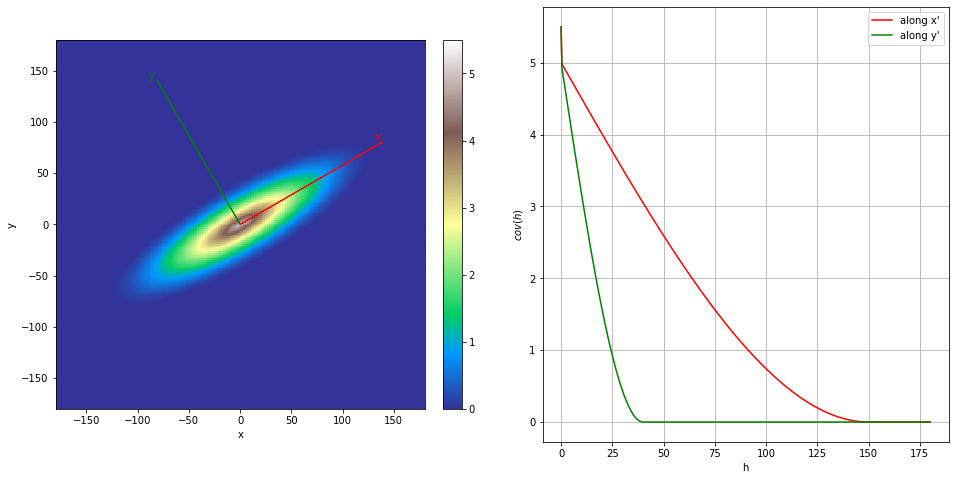

In [5]:
cov_model.plot_model(figsize=(16,8))
plt.suptitle('')
plt.show()

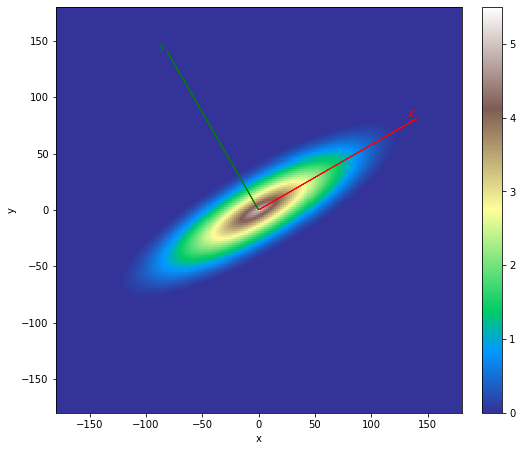

In [6]:
plt.figure(figsize=(8,8))
cov_model.plot_model(plot_curves=False)
plt.show()

Plot the variogram function. Same as above, but passing the keyword argument `vario=True` to the method `plot_model`.

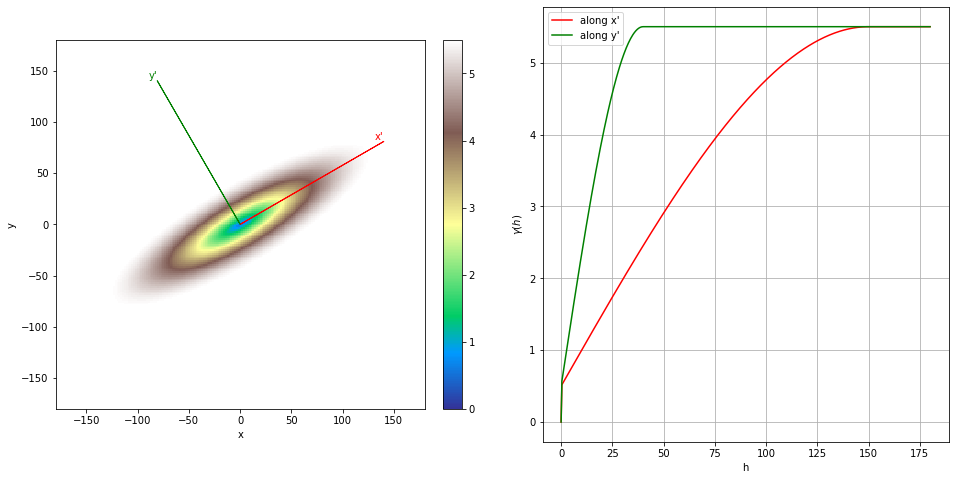

In [7]:
cov_model.plot_model(vario=True, figsize=(16,8))
plt.suptitle('')
plt.show()

The main axes x' and y' can be plotted using the method `plot_mrot`.

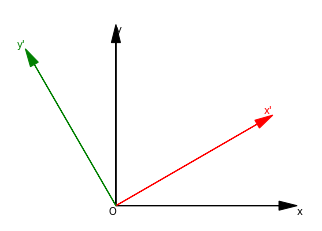

In [8]:
cov_model.plot_mrot()
plt.show()

Note that the colors used for the main axes (x' and y') can be changed in the figures above by passing the keyword arguments `color0` (axis x') and  `color1` (axis y').

### Get the sill and ranges

Get the sill and the range along each axis in the coordinates system supporting the axes of the model.

In [9]:
w = cov_model.sill() # scalar
r = cov_model.r12()  # vector (1d-array) of length 2: ranges along x', y'
print("Sill = {}".format(w))
print("Range along x' = {}, along y' = {}".format(r[0], r[1]))

Sill = 5.5
Range along x' = 150.0, along y' = 40.0


Get the maximal range along each axis of the original system Oxy.

In [10]:
rxy = cov_model.rxy()  # vector (1d-array) of length 2: "max ranges" along x, y
print("Max. range along x = {}, along y = {}".format(rxy[0], rxy[1]))

Max. range along x = 129.9038105676658, along y = 74.99999999999999


## Launching simulation and estimation in 2D
The following functions are used:
- `geone.geosclassicinterface.simulate2D` for simulation 2D (sequential Gaussian simulation, SGS),
- `geone.geosclassicinterface.estimate2D` for estimation 2D (kriging estimates and standard deviation).

These functions launch a C program running in parallel (based on *OpenMP*). The number of threads used can be specified by the optional parameter (keyword argument) `nthreads`. Specifying for this parameter a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

The covariance model in 2D (class `geone.covModel.CovModel2D`) is given as first argument.

The kriging system to solve for the evaluation / simulation in one node takes into account the informed nodes within a search ellipsoid centered around the evaluated / simulated node. The *search radius* can be specified with the keyword argument `searchRadiusRelative` (float, default: 1). In general (3D), the search for neighbors (informed nodes) is limited in the ellipsoid oriented as the covariance model, of half-axes f*(r1, r2, r3), where (r1, r2, r3) denotes the (maximal) ranges along each direction. (In 2D, the orientation is given by one angle and there is two axes (r1, r2).) 

The maximal number of neighbors retrieved is set by the keyword argument `nneigbhorMax` (int, default: `12`). The at most `nneigborMax` informed nodes within the ellipsoid are retrieved. For taking all the informed nodes within the search ellipsoid, set `nneighborMax=-1`.

The sort of the nodes within the search ellipsoid is determined by the keyword argument `searchNeighborhoodSortMode` (int: 0, 1, or 2). In general (3D), the nodes are sorted in increasing order according to:
- `searchNeighborhoodSortMode=0`: distance in the usual axes system,
- `searchNeighborhoodSortMode=1`: distance in the axes sytem supporting the covariance model and accounting for anisotropy given by the ranges,
- `searchNeighborhoodSortMode=2`: minus the evaluation of the covariance model.

Default value for `searchNeighborhoodSortMode` is set to the greatest possible value (for a stationary covariance model: `2`, otherwise if the ranges and the orientation are stationary: `1`, otherwise: `0`).

Kriging system (for simulation or estimation) are based on simple or ordinary kriging, this is specified by the keyword argument `method` (string: 'simple_kriging' (default) or 'ordinary_kriging').

*Remark:* for estimation only (function `geone.geosclassicinterface.estimate2D`), a unique neighborhood can be used, *i.e.* all data points are taken into account in the kriging system for every node, by setting the keyword argument `use_unique_neighborhood=True` (default: `False`). In this case, the parameters `searchRadiusRelative`, `nneighborMax` and `searchNeighborhoodSortMode` are ignored (unused).

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1` (default): version and warning(s) encountered, `verbose=2`: version, progress, and warning(s) encountered. Note that due to *buffering*, progress might not be displayed immediately and then could be useless.

**Alternatives**

The function `geone.multiGaussian.multiGaussianRun` can be used as a wrapper; with keyword arguments  
- `mode='simulation', algo='classic'`: wrapper for `geone.geosclassicinterface.simulate<d>D`,
- `mode='estimation', algo='classic'`: wrapper for `geone.geosclassicinterface.estimate<d>D`,

where the dimension `<d>` is automatically detected. Note also that the function `geone.multiGaussian.multiGaussianRun` allows to choose the "format" of the output by the keyword argument `output_mode`:
- `output_mode='array'`: an numpy array is returned,
- `output_mode='img'`: an "image" (class `geone.img.Img`) is returned.

### Examples

Define the simulation grid.

In [11]:
nx, ny = 220, 230  # number of cells
dx, dy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (dx, dy)
origin = (ox, oy)

### Unconditional simulations (function `geone.geosclassicinterface.simulate2D`)

In [12]:
nreal = 200
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model, dimension, spacing, origin, 
                                                        method='simple_kriging', 
                                                        searchRadiusRelative=1.0, nneighborMax=12,
                                                        nreal=nreal)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (1 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)


In [13]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(321)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, 
                                        mode='simulation', algo='classic', output_mode='img',
                                        method='simple_kriging', 
                                        searchRadiusRelative=1.0, nneighborMax=12,
                                        nreal=nreal)
# Same results (both returned images are identical):
np.all(out.val== geosclassic_output['image'].val) # should be True

### Retrieve the results (and display)
The function `geone.geosclassicinterface.simulate2D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The realizations are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with as many variables as realizations (the i-th variable being the i-th realization).

The total number of warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [14]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(1, ['WARNING 02015: solving kriging system fails (do as if no neighbor)'])

In [15]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

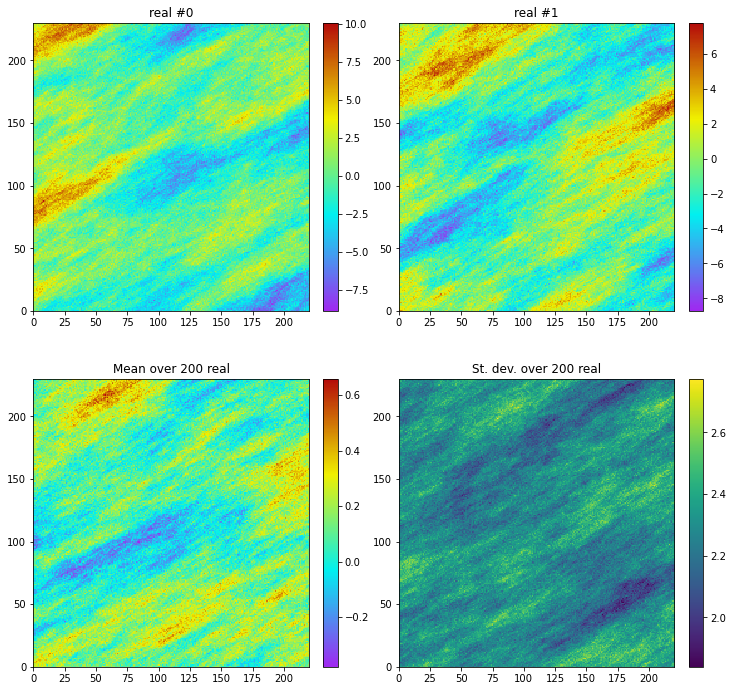

In [16]:
plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(simul, iv=i)
    plt.title('real #{}'.format(i))

# mean of all real
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(simul_mean)
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.title('St. dev. over {} real'.format(nreal))

plt.show()

### Conditional simulations (hard data) (function `geone.geosclassicinterface.simulate2D`)
Define hard data. Note that the conditioning values will be attached to the grid cells containing the corresponding conditioning locations.

In [17]:
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

Launch the simulations and plot.

In [18]:
nreal = 200
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging', nreal=nreal)

# Retrieve the realizations
simul = geosclassic_output['image']

# Compute mean and standard deviation (pixel-wise)
simul_mean = gn.img.imageContStat(simul, op='mean')
simul_std = gn.img.imageContStat(simul, op='std')

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (1 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)


In [19]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
np.random.seed(321)
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, x=x, v=v,
                                        mode='simulation', algo='classic', output_mode='img',
                                        method='simple_kriging', nreal=nreal)
# Same results (both returned images are identical):
np.all(out.val== geosclassic_output['image'].val) # should be True

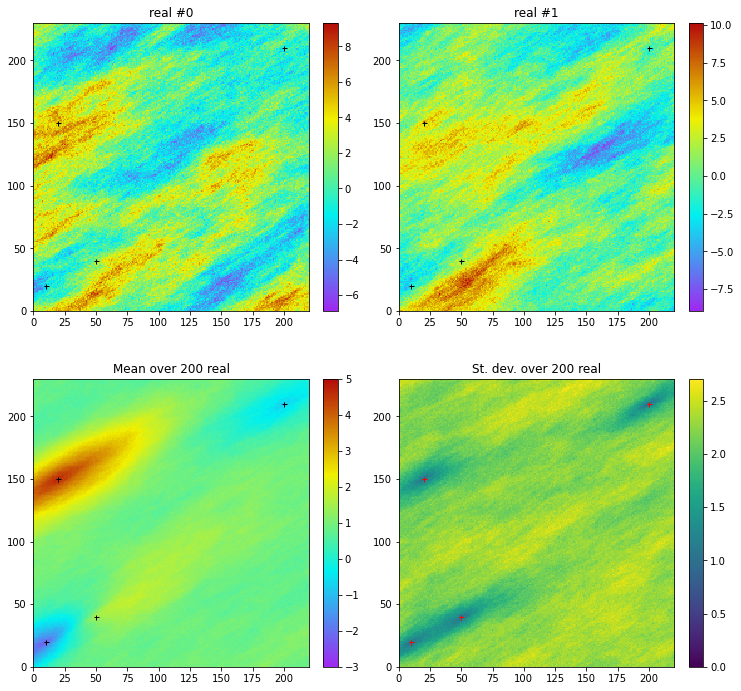

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(simul, iv=i)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('real #{}'.format(i))

# mean of all real
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(simul_mean)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Mean over {} real'.format(nreal))

# standard deviation of all real
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(simul_std, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('St. dev. over {} real'.format(nreal))

plt.show()

### Estimation: kriging estimates and standard deviation
#### Function `geone.geosclassicinterface.estimate2D`

In [21]:
# Increase searchRadiusRelative to avoid "discontinuities"
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        searchRadiusRelative=2.0)

# # Or use a unique neighborhood
# geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model, dimension, spacing, origin, 
#                                                         x=x, v=v, method='simple_kriging',
#                                                         use_unique_neighborhood=True)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (54 times in all):
#  1: WARNING 02001: a neigbhor has been dropped (solving kriging system)
#  2: WARNING 02015: solving kriging system fails (do as if no neighbor)


In [22]:
# %%script false --no-raise-error # skip this cell! (comment this line to run the cell)

# Alternative:
out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, x=x, v=v,
                                        mode='estimation', algo='classic', output_mode='img',
                                        method='simple_kriging', searchRadiusRelative=2.0)
# # Or with a unique neighborhood
# out = gn.multiGaussian.multiGaussianRun(cov_model, dimension, spacing, origin, x=x, v=v,
#                                         mode='estimation', algo='classic', output_mode='img',
#                                         method='simple_kriging', use_unique_neighborhood=True)
# Same results (both returned images are identical):
np.all(out.val== geosclassic_output['image'].val) # should be True

True

### Retrieve the results (and display)
The function `geone.geosclassicinterface.estimate2D` returns the dictionary

`geosclassic_output = {'image':image, 'nwarning':nwarning, 'warnings':warnings}`

The kriging estimate and kriging standard deviation are stored in `geosclassic_output['image']`, an *image* (class `geone.img.Img`) with two variables: the first variable (index 0) is the kriging estimate, and the second variable (index 1) is the kriging standard deviation.

As for the function `geone.geosclassicinterface.simulate2D`, the warning(s) encountered during the run are stored in `geosclassic_output['nwarning']` (*int*), and all the distinct warning messages are stored in `geosclassic_output['warnings']` (it is a list, possibly empty).

In [23]:
# Retrieve the results of estimation
estim = geosclassic_output['image']

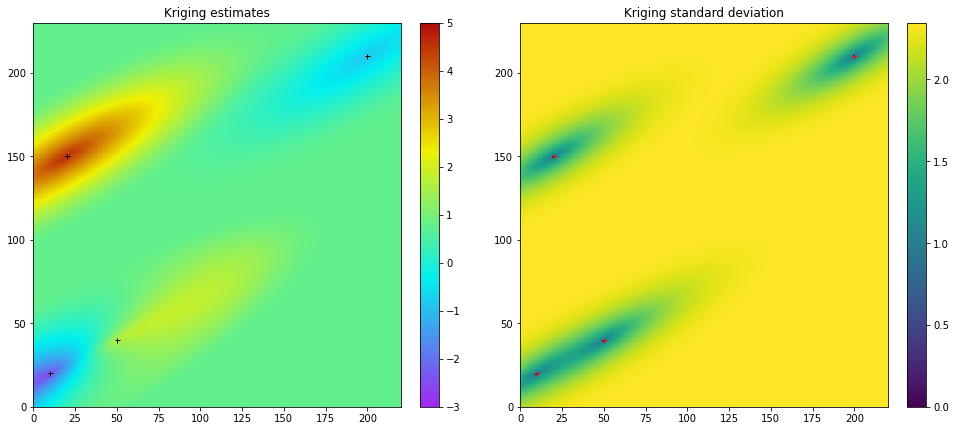

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

# kriging estimates
plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(estim, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(estim, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='red', markersize=5) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

### Simple and ordinary kriging

In [25]:
# simulation based on simple kriging
np.random.seed(444)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging', 
                                                        nreal=1)
simul_simple_krig = geosclassic_output['image']

# estimation based on simple kriging
np.random.seed(444)
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        use_unique_neighborhood=True)
estim_simple_krig = geosclassic_output['image']

# simulation based on ordinary kriging
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='ordinary_kriging',
                                                        nreal=1)
simul_ordinary_krig = geosclassic_output['image']

# estimation based on ordinary kriging
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='ordinary_kriging', 
                                                        use_unique_neighborhood=True)
estim_ordinary_krig = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (40 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


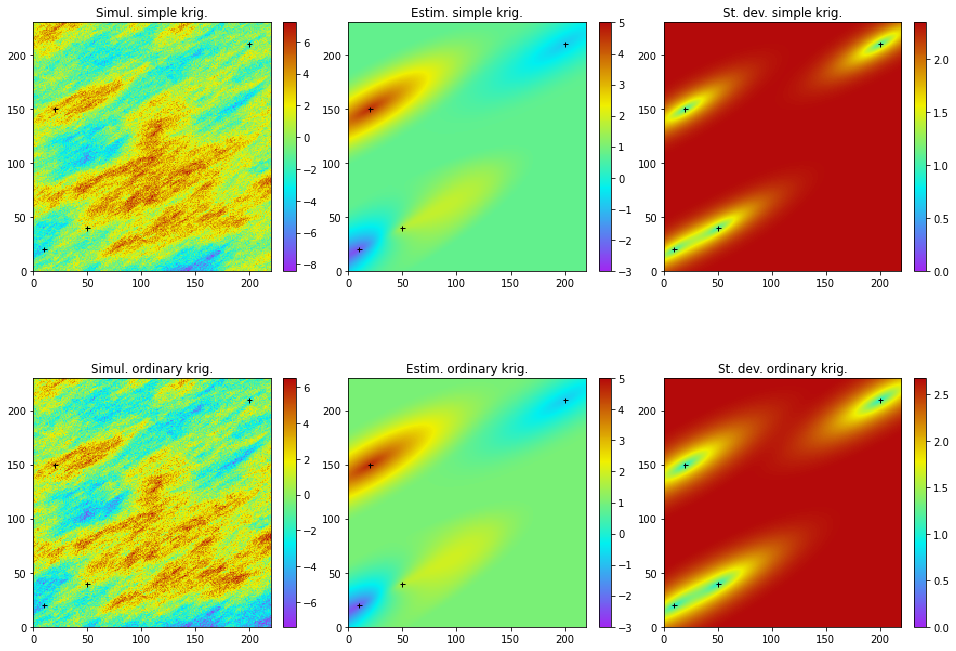

In [26]:
# plot
fig, ax = plt.subplots(2, 3, figsize=(16,12))

plt.subplot(2, 3, 1)
gn.imgplot.drawImage2D(simul_simple_krig, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Simul. simple krig.')

plt.subplot(2, 3, 2)
gn.imgplot.drawImage2D(estim_simple_krig, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Estim. simple krig.')

plt.subplot(2, 3, 3)
gn.imgplot.drawImage2D(estim_simple_krig, iv=1)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('St. dev. simple krig.')

plt.subplot(2, 3, 4)
gn.imgplot.drawImage2D(simul_ordinary_krig, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Simul. ordinary krig.')

plt.subplot(2, 3, 5)
gn.imgplot.drawImage2D(estim_ordinary_krig, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Estim. ordinary krig.')

plt.subplot(2, 3, 6)
gn.imgplot.drawImage2D(estim_ordinary_krig, iv=1)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('St. dev. ordinary krig.')

plt.show()

### Simulations with imposed mean and/or variance (simple kriging)
Mean and variance in the simulation grid can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).

### Simulations with constant mean and variance
Set mean to $3.0$ and variance to the double of the covariance model sill.

In [27]:
# Simulation
nreal = 2
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, 
                                                        mean=3., var=2*cov_model.sill(), nreal=nreal)
simul = geosclassic_output['image']

# Estimation
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        use_unique_neighborhood=True,
                                                        mean=3., var=2*cov_model.sill())
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (40 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)


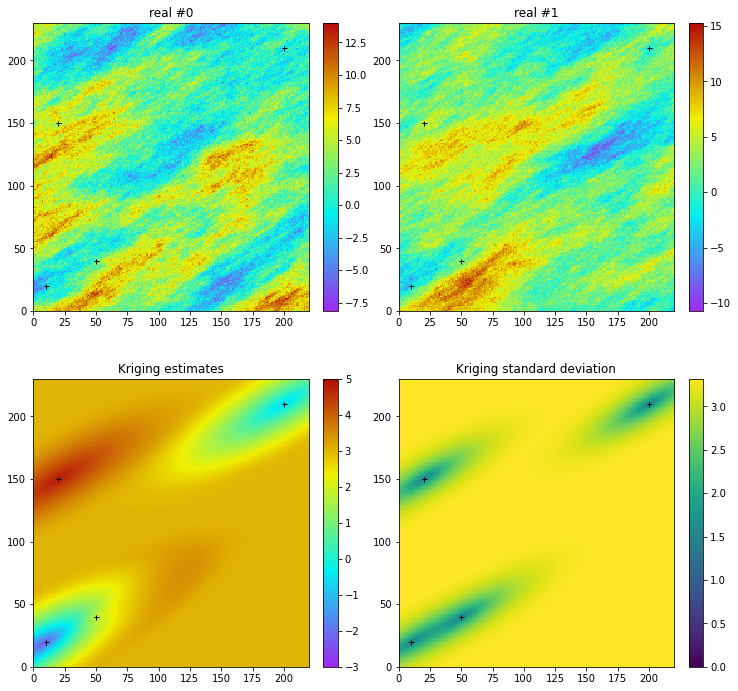

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(simul, iv=i)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('real #{}'.format(i))

# kriging estimates
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(estim, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(estim, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

### Simulations with non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

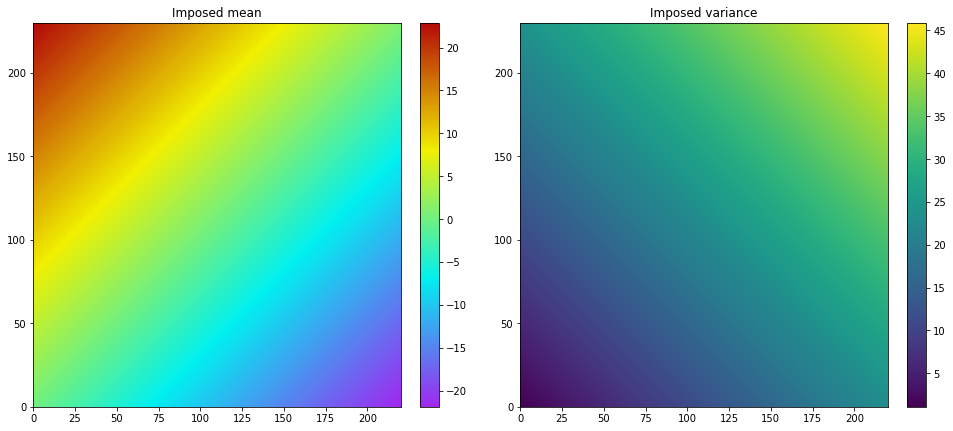

In [29]:
# Coordinates of the center of grid cells
xg = ox + dx*(0.5+np.arange(nx))
yg = oy + dy*(0.5+np.arange(ny))

# Create a meshgrid from the center of grid cells
xx, yy = np.meshgrid(xg, yg)

# Define the mean and variance on the simulation grid
mean = 0.1*(yy - xx)         # define mean on the simulation grid
var = 1 + 0.1*(xx + yy)      # define variance on the simulation grid

# Fill image for display
im = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((mean, var)))

# Display imposed mean and var
fig, ax = plt.subplots(1, 2, figsize=(16,8))

plt.subplot(1, 2, 1)
gn.imgplot.drawImage2D(im, iv=0)
plt.title('Imposed mean')

plt.subplot(1, 2, 2)
gn.imgplot.drawImage2D(im, iv=1, cmap='viridis')
plt.title('Imposed variance')

plt.show()

In [30]:
# Simulation
nreal = 2
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, 
                                                        mean=mean, var=var, nreal=nreal)
simul = geosclassic_output['image']

# Estimation
geosclassic_output = gn.geosclassicinterface.estimate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, method='simple_kriging',
                                                        use_unique_neighborhood=True,
                                                        mean=mean, var=var)
estim = geosclassic_output['image']

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete
Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete

Warnings encountered (40 times in all):
#  1: WARNING 02015: solving kriging system fails (do as if no neighbor)


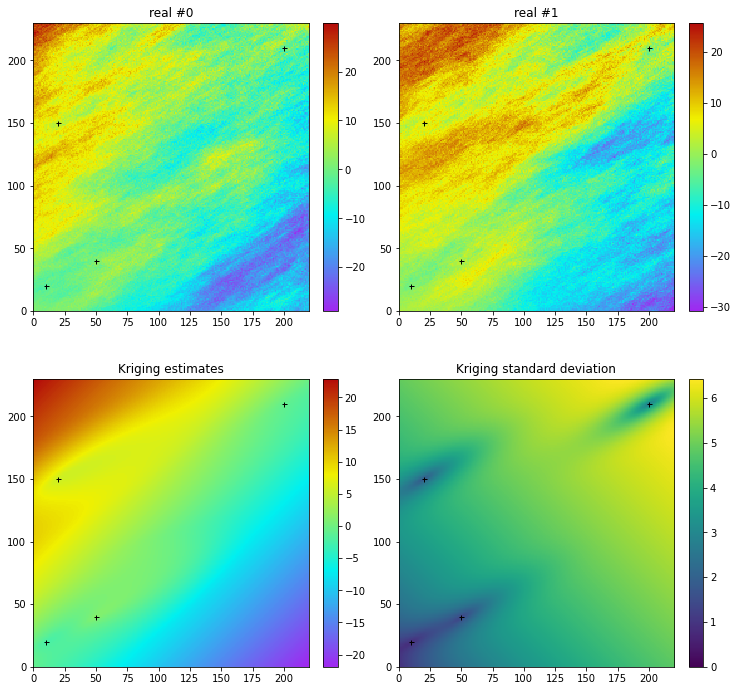

In [31]:
# Plot the realizations and the results of estimation
fig, ax = plt.subplots(2, 2, figsize=(12,12))

# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(simul, iv=i)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
    plt.title('real #{}'.format(i))

# kriging estimates
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(estim, iv=0)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging estimates')

# kriging standard deviation
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(estim, iv=1, cmap='viridis')
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.title('Kriging standard deviation')

plt.show()

## Conditioning with inequality data (simulation only)

Simulation can be done with usual hard data and inequality data consisting in a lower and/or upper bound at some points.

The conditioning locations with inequality data are first simulated (with truncated gaussian distribution) sequentially. Then, these locations are re-simulated following a new path as many times as needed (Gibbs sampler); the total number of paths will be between `nGibbsSamplerPathMin` and `nGibbsSamplerPathMax` (keyword arguments, default: 50 and 200 respectively).

Define hard data and inequality data with minimal value and inequality with maximal value. Note that the conditioning values (hard, min. or max.) will be attached to the grid cells containing the corresponding conditioning locations.

In [32]:
# Hard data
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ -3.,  2.,   5.,  -1.] # values

# Inequality data
xIneqMin = np.array([[ 125., 100.],  # 1st point
                     [ 175.,  60.]]) # 2nd point
vIneqMin = [4., -2.2]  # lower bounds

xIneqMax = np.array([[  75., 175.],  # 1st point
                     [ 175.,  60.]]) # 2nd point
vIneqMax = [-4.1, -2.]  # upper bounds
# Note: second inequality data point has a lower bound and an upper bound

In [33]:
nreal = 200
np.random.seed(321)
geosclassic_output = gn.geosclassicinterface.simulate2D(cov_model, dimension, spacing, origin, 
                                                        x=x, v=v, 
                                                        xIneqMin=xIneqMin, vIneqMin=vIneqMin,
                                                        xIneqMax=xIneqMax, vIneqMax=vIneqMax,
                                                        searchRadiusRelative=1.,
                                                        method='simple_kriging', nreal=nreal)

Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20220627 / OpenMP 7 thread(s)]
Geos-Classic run complete


In [34]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute min and max (pixel-wise)
simul_min = gn.img.imageContStat(simul, op='min')
simul_max = gn.img.imageContStat(simul, op='max')

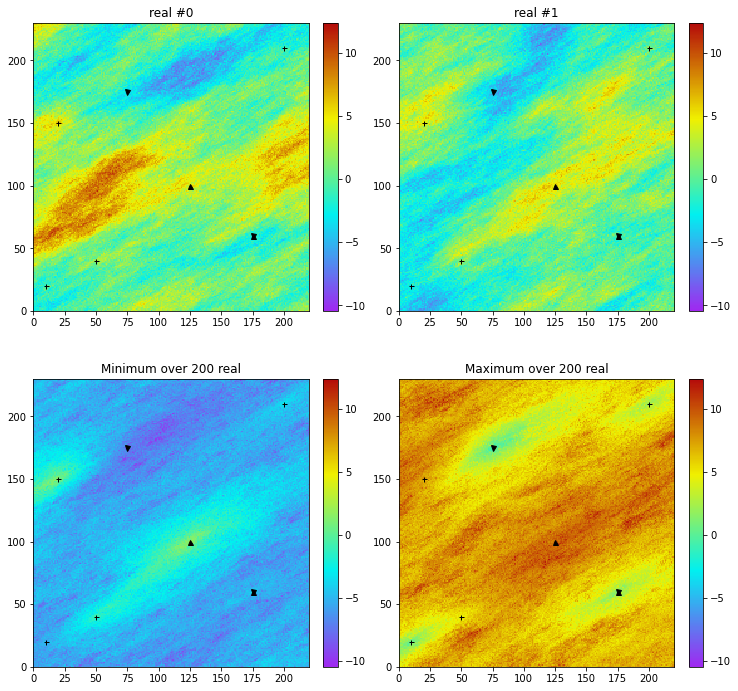

In [35]:
# Plot the realizations and the results of estimation
vmin = np.min(simul.val)
vmax = np.max(simul.val)

fig, ax = plt.subplots(2, 2, figsize=(12,12))
# 2 first real ...
for i in (0, 1):
    plt.subplot(2, 2, i+1)
    gn.imgplot.drawImage2D(simul, iv=i, vmin=vmin, vmax=vmax)
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add hard data locations
    plt.plot(xIneqMin[:,0],xIneqMin[:,1], '^', c='black', markersize=5) # add inequality (min) data locations
    plt.plot(xIneqMax[:,0],xIneqMax[:,1], 'v', c='black', markersize=5) # add inequality (max) data locations
    plt.title('real #{}'.format(i))

# min
plt.subplot(2, 2, 3)
gn.imgplot.drawImage2D(simul_min, iv=0, vmin=vmin, vmax=vmax)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.plot(xIneqMin[:,0],xIneqMin[:,1], '^', c='black', markersize=5) # add inequality (min) data locations
plt.plot(xIneqMax[:,0],xIneqMax[:,1], 'v', c='black', markersize=5) # add inequality (max) data locations
plt.title('Minimum over {} real'.format(nreal))

# max
plt.subplot(2, 2, 4)
gn.imgplot.drawImage2D(simul_max, iv=0, vmin=vmin, vmax=vmax)
plt.plot(x[:,0],x[:,1], '+', c='black', markersize=5) # add conditioning point locations
plt.plot(xIneqMin[:,0],xIneqMin[:,1], '^', c='black', markersize=5) # add inequality (min) data locations
plt.plot(xIneqMax[:,0],xIneqMax[:,1], 'v', c='black', markersize=5) # add inequality (max) data locations
plt.title('Maximum over {} real'.format(nreal))

plt.show()

### Check that conditioning data are honoured

In [36]:
# Get index of conditioning location in simulation grid
hd_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0, dx, dy, 1., ox, oy, 0.) for xx in x]
ineqMin_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0, dx, dy, 1., ox, oy, 0.) for xx in xIneqMin]
ineqMax_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0, dx, dy, 1., ox, oy, 0.) for xx in xIneqMax]

# Min and max value at hard data
min_value_at_hd = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
max_value_at_hd = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in hd_grid_index])
print('Hard data value:\n{}'.format(v))
print('Min and max value at hard data:\n{}\n{}'.format(
    min_value_at_hd, max_value_at_hd))
print('Hard data, abs error max: {}\n'.format(max(np.ptp(min_value_at_hd - v), np.ptp(max_value_at_hd - v))))
      
# Min and max value at inequality data with minimal value
min_value_at_ineqMin = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
max_value_at_ineqMin = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMin_grid_index])
print('Minimal data value:\n{}'.format(vIneqMin))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMin, max_value_at_ineqMin))
print('All min data value honoured ? {}\n'.format(np.all(min_value_at_ineqMin > vIneqMin)))

# Min and max value at inequality data with maximal value
min_value_at_ineqMax = np.asarray([simul_min.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
max_value_at_ineqMax = np.asarray([simul_max.val[0][grid_index[::-1]] for grid_index in ineqMax_grid_index])
print('Maximal data value:\n{}'.format(vIneqMax))
print('Min and max value at inequality data with maximal value:\n{}\n{}'.format(
    min_value_at_ineqMax, max_value_at_ineqMax))
print('All max data value honoured ? {}'.format(np.all(max_value_at_ineqMax < vIneqMax)))

Hard data value:
[-3.0, 2.0, 5.0, -1.0]
Min and max value at hard data:
[-3.  2.  5. -1.]
[-3.  2.  5. -1.]
Hard data, abs error max: 0.0

Minimal data value:
[4.0, -2.2]
Min and max value at inequality data with maximal value:
[ 4.03772695 -2.19843314]
[ 9.17818885 -2.00048207]
All min data value honoured ? True

Maximal data value:
[-4.1, -2.0]
Min and max value at inequality data with maximal value:
[-6.90633671 -2.19843314]
[-4.10171843 -2.00048207]
All max data value honoured ? True
